In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import shap

Import data prepared in previous steps (only data for 2018 survey, full time employment, and removed outliers) and used for all machine learning models. The target is hourly rate and predictors are economic sector (nace), company size (esize_class), gender, age class, profession (lpk), education. All these are categorical variables. Single numerical variable is experience in years.

In [10]:
data = pd.read_csv('../Data/LT_DU_data_for_ML.csv') 
data.head()

,nace,esize_class,gender,age_class,lpk,education,experience,target
0,C,1_49,M,40-49,p721,G2,13,8.20
1,C,1_49,F,40-49,p334,G2,0,2.51
2,M,50_249,F,40-49,p522,G2,18,2.19
3,M,50_249,F,40-49,p522,G2,12,2.19
4,M,50_249,F,14-29,p522,G2,0,2.19


One fifth of records is kept for testing of models.

In [11]:
y = data['target']
X = data.drop(columns='target')

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=0)

print('Dataset lengths:', 'train', len(y_train), ', test', len(y_test))

Dataset lengths: train 26114 , test 6529


# Model and predictions

## Initial model

Initial XGB model used to test pipline and estimate the baseline accuracy. Numerical feature is scaled with [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) and categorical features are encoded using [OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) with manual encoding for selected features. Company size, age_class and education are sorted by expected effect on hourly rate. Profession is sorted by the code value. Economic sector encoded according to the appearance order in train dataset.

In [12]:
nace = X_train['nace'].unique()
gender = X_train['gender'].unique()
esize_class = np.array(['1_49', '50_249','GT_250'], dtype=object)
age_class = np.array(['14-29','30-39', '40-49', '50-59','60+'], dtype=object)
education = np.array([ 'G1', 'G2', 'G3', 'G4'], dtype=object)
lpk = np.sort(X_train['lpk'].unique())

# Initial model

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from xgboost import XGBRegressor

numeric_preprocessor = Pipeline(steps=[("scaler", StandardScaler())])

categorical_preprocessor = Pipeline(steps=[("ordinal", OrdinalEncoder(categories=[nace, esize_class, gender, age_class, lpk, education]))])

preprocessor = ColumnTransformer(
    [
        ("categorical", categorical_preprocessor, ['nace', 'esize_class', 'gender', 'age_class', 'lpk', 'education']),
        ("numerical", numeric_preprocessor, ['experience'])
    ]
)

model = Pipeline([('prep', preprocessor), ('regr', XGBRegressor())])
model.fit(X=X_train, y=y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder(categories=[array(['C', 'N', 'D', 'E', 'Q', 'G', 'H', 'I', 'M', 'O', 'P', 'F', 'J',
       'S', 'K', 'L', 'R', 'B'], dtype=object),
                                                                                              array(['1_49', '50_249', 'GT_250'], dtype=object),
                                                                                              array(['M', 'F'], dtype=object),
                                                                                              array(['14-29', '30-39', '40-49', '50-59', '60+'], dtype=ob...
                              feature_types=None, gamma=0, gpu_id=-1,
                              grow_policy='depthwise', importance_type=None,
                              interaction_constraints='',
                              learning_rate=0.300000012, max_bin=256,
                              max_cat_threshold=64, max_cat_to_onehot=4,
                              max_delta_step=0, max_depth=6, max_leaves=0,
                              min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=0, num_parallel_tree=1, predictor='auto',
                              random_state=0, ...))])

Function to print model prediction RMSE and R2

In [14]:
def print_model_rmse_r2(model, X_train, y_train, X_test, y_test):
    """ 
    Function to print model prediction RMSE and R2
    for train and test datasets
        Parameters:
        model - model to evaluate
        X_train - train features
        y_train - train target 
        X_test - test features
        y_test - test target
    """
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred)).round(3)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred)).round(3)

    r2_train = r2_score(y_train, y_train_pred).round(3)
    r2_test = r2_score(y_test, y_test_pred).round(3)

    print('Train: RMSE=', rmse_train, ' R2=', r2_train,
        '\nTest: RMSE=', rmse_test, ' R2=', r2_test)

RMSE and R2 of initial model predicions for train and test datasets

In [15]:
print_model_rmse_r2(model, X_train, y_train, X_test, y_test)

Train: RMSE= 1.343  R2= 0.722 
Test: RMSE= 1.639  R2= 0.583


## Randomized Search CV

Randomized cross validation was used to tune model. Randomized search used to quickly explore parameter space and test if tuning of hyperparameters potentially can provide substantial gains over initial model.

In [16]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
model = Pipeline([('prep', preprocessor), ('regr', XGBRegressor())])

grid = {'regr__max_depth':np.arange(5, 15, dtype=int),
        'regr__eta': np.linspace(0.05, 0.55, 9),
        'regr__gamma': np.linspace(1,  3,  9),
        'regr__min_child_weight': np.arange(1, 6, dtype=int),
        'regr__subsample': np.linspace(0.3, 1, 9), 
        'regr__colsample_bytree': np.linspace(0.3,  1,  9),
        'regr__alpha': np.linspace(0,  1,  9),
        'regr__lambda' : [1, 5, 10, 20],
        'regr__learning_rate': np.linspace(0.05,  0.2,  4)
         }
search = RandomizedSearchCV(model, grid, scoring='neg_root_mean_squared_error', n_iter = 150, cv=cv, n_jobs=-1)
results = search.fit(X=X_train,y=y_train)

results_pd = pd.DataFrame(results.cv_results_)
results_pd.filter(regex='rank|regr|mean_test_score|std_test_score',axis=1).sort_values('rank_test_score').head().T

,24,11,44,63,91
param_regr__subsample,0.9125,0.7375,0.9125,0.3875,0.5625
param_regr__min_child_weight,1,3,1,4,5
param_regr__max_depth,8,14,9,9,14
param_regr__learning_rate,0.05,0.05,0.1,0.05,0.1
param_regr__lambda,5,5,10,1,20
param_regr__gamma,1.5,2.0,2.5,2.5,1.0
param_regr__eta,0.3625,0.175,0.1125,0.425,0.3625
param_regr__colsample_bytree,0.7375,0.9125,0.825,0.7375,0.7375
param_regr__alpha,0.125,0.625,1.0,0.625,1.0
mean_test_score,-1.652668,-1.653088,-1.653791,-1.655172,-1.656223


In [19]:
best_model=results.best_estimator_
best_model

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder(categories=[array(['C', 'N', 'D', 'E', 'Q', 'G', 'H', 'I', 'M', 'O', 'P', 'F', 'J',
       'S', 'K', 'L', 'R', 'B'], dtype=object),
                                                                                              array(['1_49', '50_249', 'GT_250'], dtype=object),
                                                                                              array(['M', 'F'], dtype=object),
                                                                                              array(['14-29', '30-39', '40-49', '50-59', '60+'], dtype=ob...
                              enable_categorical=False, eta=0.3625,
                              eval_metric=None, feature_types=None, gamma=1.5,
                              gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              lambda=5, learning_rate=0.05, max_bin=256,
                              max_cat_threshold=64, max_cat_to_onehot=4,
                              max_delta_step=0, max_depth=8, max_leaves=0,
                              min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=0, ...))])

In [20]:
print_model_rmse_r2(best_model, X_train, y_train, X_test, y_test)

Train: RMSE= 1.487  R2= 0.658 
Test: RMSE= 1.615  R2= 0.596


Variability of parameter values is significant for five best iterations and performance gain over untuned initial model is marginal. Small changes of scores suggest that the loss gradient is small near best iterations. The model with parameters from best iteration will be used for further analysis. The best model R2 (0.596) for test data is almost the same as using auto encoding (0.604). 

## Feature importance

We tested the feature importance using native XGBoost, permutation and [SHAP](https://shap.readthedocs.io/en/latest/) feature importance methods.

### XGBoost

In [21]:
best_regr = best_model.named_steps["regr"]
feature_importances = best_regr.feature_importances_

prep = best_model.named_steps["prep"]
feature_names = prep.get_feature_names_out()

importances = pd.DataFrame({'importance': feature_importances }, index=feature_names )
importances.sort_values('importance', ascending=False)

,importance
categorical__lpk,0.340183
categorical__esize_class,0.279252
categorical__education,0.186450
categorical__gender,0.077425
categorical__nace,0.049556
categorical__age_class,0.033981
numerical__experience,0.033152


### SHAP

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


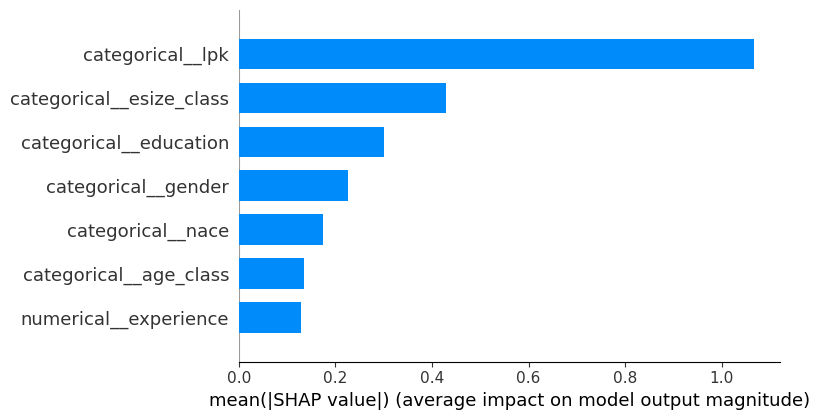

In [22]:
explainer = shap.TreeExplainer(best_regr, feature_names=feature_names)
shap_values = explainer(prep.transform(X_test))
shap.summary_plot(shap_values, plot_type="bar");

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


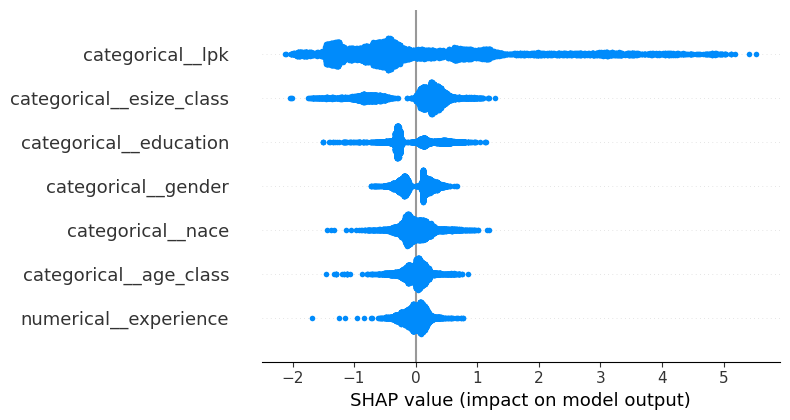

In [23]:
shap_values = shap.TreeExplainer(best_model['regr']).shap_values(prep.transform(X_test))
shap.summary_plot(shap_values, feature_names=feature_names );

## Permutation importance

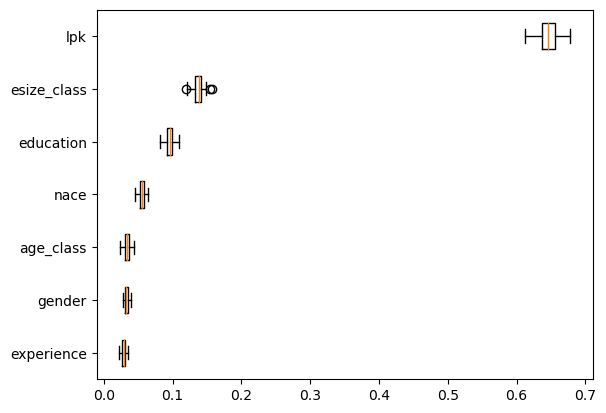

In [24]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(best_model, X_test, y_test,  n_repeats=100,  random_state=0)
importance_order = perm_importance.importances_mean.argsort()
fig, ax = plt.subplots()
plt.boxplot(
    perm_importance.importances[importance_order].T,
    vert=False,
    labels=np.array(X_test.columns)[importance_order],
);

By far the most important feature is profession (lpk) followed by company size and education. The economic sector, age, gender and experience are less important. Feature immportance results might be affected by large cardinality of lpk and nace.

# Model (Pipline) Serialization 

In [25]:
import joblib
joblib.dump(best_model, './Models/XGBoost_manual_cat_model.joblib')

['./Models/XGBoost_manual_cat_model.joblib']